In this notebook, we'll illustrate the paper "SAMSelect: An Automated Spectral Index Search for Marine Debris using Segment-Anything." SAMSelect is an automated algorithm designed to identify the best spectral band combinations for creating three-channel visualizations from multispectral imagery. Initially developed for detecting marine debris in Sentinel-2 data, the algorithm is highly adaptable and can be applied to both terrestrial and marine contexts. By building on the Segment Anything Model (SAM), SAMSelect approximates the process of visual inspection typically performed by domain experts. Using a few annotated objects-of-interest, SAM automates the search for the best visualizations, quickly testing numerous spectral band combinations and exhaustively exploring a vast search space, as illustrated in the figure below.

![SAMSelect](../doc/Flowchart_SAMSelect.png)

Before starting the tutorial, please download a small section of a Sentinel-2 scene (specifically, Durban on 2019-04-24). During this period, Easter floods occurred between April 18-22, 2019, causing heavy rainfall (>10mm/hr) and resulting in a large outwash of plastic. The scene has been described in Biermann et al. (2020), with annotations from the FloatingObjects produced in Mifdal et al. (2021) and Russwurm et al. (2023).

Please download the files from here: https://drive.google.com/drive/folders/1UBy1mnVWgmaF_1nKgGyrYtS_L52mACIy?usp=sharing, and store these into the /data/ folder in the repository.

We highly recommend using your own Sentinel-2 scene with a greater number of polygon annotations to improve the reliability of the results. For now, only a single patch is used to showcase the usability of the algorithm, meaning the results differ from those in the paper.

## Set-up environment
Before running this demo, please follow these instructions in your terminal:
```
python setup_environment.py

conda activate samselect

conda install pytorch=2.4.1 torchvision=0.17.2 torchaudio=2.2.2 pytorch-cuda=12.4 -c pytorch -c nvidia

pip install -e .
```

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

# Set the working directory to the root of the project
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(project_root)
sys.path.append(project_root)

### Visualize in true-colour

In [2]:
# Function to apply histogram stretching
def histogram_stretch(image, lower_percentile=5, upper_percentile=95):
    lower_bound = np.percentile(image, lower_percentile)
    upper_bound = np.percentile(image, upper_percentile)
    stretched_image = np.clip(image, lower_bound, upper_bound)
    stretched_image = (stretched_image - lower_bound) / (upper_bound - lower_bound)
    return stretched_image

In [3]:
from scripts.utils.image_predictions import get_img

# Load in data with true-colour and Floating Debris Index (FDI, Biermann et al. (2020))
band_list = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"] # Sentinel-2 L2A bands
tif_path = 'data/demo_durban_20190424.tif' # Path to the TIFF file
polygon_path = 'data/demo_durban_20190424.shp' # Path to the polygon annotations
images_vis, batch_label, point_prompts, point_labels, patch_ids = get_img(tif_path, polygon_path,
                                                                          band_list, # All bands available within the TIFF
                                                                          ['B4', 'B3', 'B2'], # Band combination to visualize, true-colour
                                                                          'bc') # Visualization module, band composite
images_fdi, _, _, _, _ = get_img(tif_path, polygon_path,
                                band_list, # All bands available within the TIFF
                                ["B8", "B6", "B11"], # Bands used for calculating the FDI (Biermann et al., 2020)
                                'fdi')

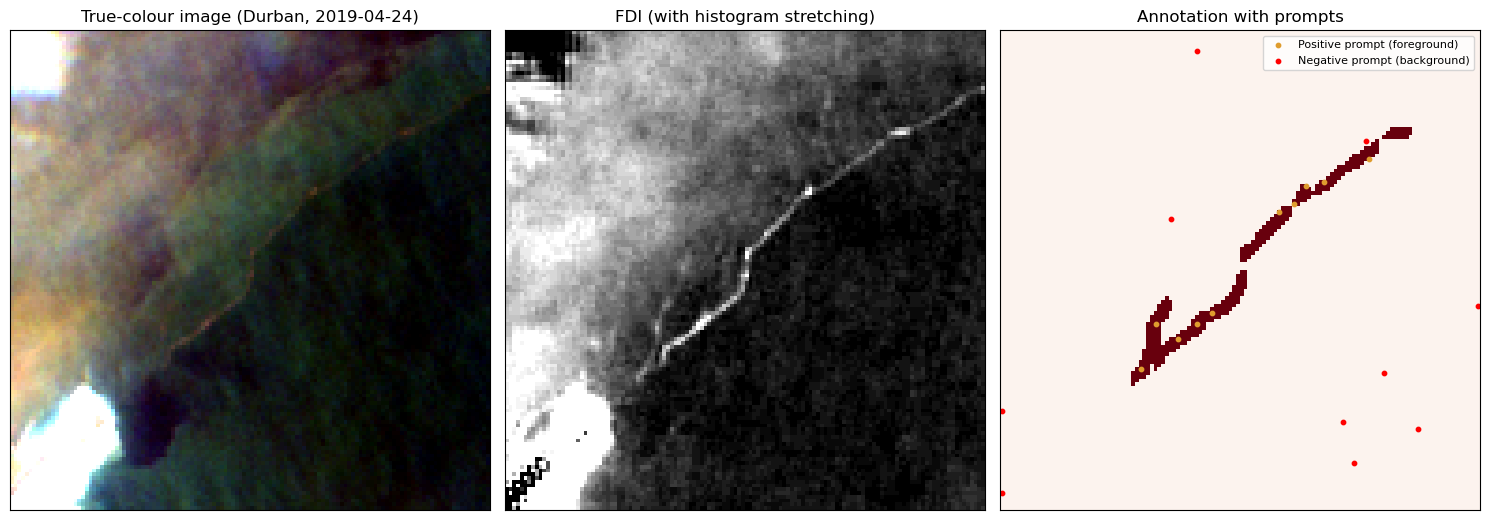

In [4]:
# Define custom colormap
binary_cmap = ListedColormap(['#FCF3EE', '#68000D'])

# Prepare figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 7))  # 1 row, 3 columns

# Plot True-Color Image (RGB) with histogram stretching
image_vis = images_vis[0].permute(1, 2, 0).numpy()
stretched_image_vis = np.stack([histogram_stretch(image_vis[:, :, i]) for i in range(image_vis.shape[2])], axis=2)
axes[0].imshow(stretched_image_vis)
axes[0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[0].set_title(f"True-colour image (Durban, 2019-04-24)")

# Plot the same data using the Floating Debris Index (FDI) with histogram stretching
image_fdi = images_fdi[0].permute(1, 2, 0).numpy()
stretched_image_fdi = np.stack([histogram_stretch(image_fdi[:, :, i]) for i in range(image_fdi.shape[2])], axis=2)
axes[1].imshow(stretched_image_fdi)
axes[1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[1].set_title(f"FDI (with histogram stretching)")

# Plot Binary Label with Prompts
axes[2].imshow(batch_label[0].squeeze(0), cmap=binary_cmap)  # Ensure the label is permuted correctly for RGB display
axes[2].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[2].set_title("Annotation with prompts")

# Remove padding from point prompts
valid_mask = ~torch.all(point_prompts == 0, dim=-1)  # Mask where points are not [0, 0]
valid_points = point_prompts[valid_mask].numpy()  # Extract valid points as a NumPy array
valid_p_labels = point_labels[point_labels != 99].numpy()  # Extract valid patch IDs

# Plot point prompts on the label subplot
positive_scatter = axes[2].scatter([], [], c='#DF9C2E', s=10, label='Positive prompt (foreground)')
negative_scatter = axes[2].scatter([], [], c='red', s=10, label='Negative prompt (background)') # Randomly generated in the patch

# Plot point prompts on the label subplot
for point, p_label in zip(valid_points, valid_p_labels):
    color = '#DF9C2E' if p_label == 1 else 'red'
    axes[2].scatter(point[0], point[1], c=color, s=10)

# Add legend for points
axes[2].legend(loc='upper right', fontsize=8)

# Display the subplots
plt.tight_layout()
plt.show()


# Execute SAMSelect

### `samselect` Function Arguments

- **`tif_path`** (`str`):  
    - **Description**: The path to the Sentinel-2 scene.  
    - **Example**: `'data/demo_durban_20190424.tif'`

- **`polygon_path`** (`str`):  
    - **Description**: The path to the polygon annotations for the Sentinel-2 scene.  
    - **Example**: `'data/demo_durban_20190424.shp'`

- **`band_list`** (`list of str`):  
    - **Description**: Specifies the available multispectral bands in the TIFF files. For Sentinel-2 data, it might look like `["B1", "B2", "B3", "B4", ...]`  
    - **Example**: `['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']` for Sentinel-2 L2A data

- **`narrow_search_bands`** (`list of str, optional`):  
    - **Description**: Limits the spectral search space to a subset of the bands in `band_list`. This can significantly reduce computation time. Note that the bands listed here must exactly match those provided in `band_list`.  
    - **Example**: `['B2', 'B3', 'B4', 'B8', 'B8A']` for narrowing down analysis to visible and near-infrared bands
    - **Default**: `None`

- **`scaling`** (`str`):  
    - **Description**: The normalization function applied to the reflectance data to scale into a `[0, 255]` range for RGB data. Default is percentile scaling (1%-99%), but different scaling options are available in the dataloader.  
    - **Example**: `'percentile_1-99'` normalize values between the 1st and 99th percentiles

- **`equation`** (`list of str`):  
    - **Description**: Specifies the type of visualizations SAMSelect will compute. The following visualization options are available:  
        - **`bc`**: Band Composites (BC) / false-colour composites using three spectral bands  
        - **`ndi`**: Normalized Difference Indices (NDI), such as NDVI or NDWI  
        - **`ssi`**: Spectral Shape Indices (SSI), such as the Floating Algae Index  
        - **`top`**: Spectral Index Composite (SIC), which uses a similar approach to `bc` but instead of individual spectral bands, the top-10 most informative indices (NDIs and SSIs) are assigned to RGB channels. This option requires prior calculation of NDIs and SSIs  
    - **Example**: `['bc', 'ndi', 'ssi', 'top']`

- **`model_type`** (`str`):  
    - **Description**: Defines the image encoder variant for SAM. Default is `vit_b` which is recommended for its performance and computation time.  
    - **Example**: `'vit_b'` ViT-Base

In [ ]:
#NOTE: This cell takes up to 3-8 minutes using CPU; Significantly less using GPU

from scripts.models.samselect import samselect
equation_list = ['bc', 'ndi'] # For demonstration purposes, we limit the visualization modules to BC and NDIs; Other options are listed above
for eq in equation_list: 
    samselect(tif_path, polygon_path, band_list, 
            narrow_search_bands = ['B1', 'B2', 'B3', 'B4', 'B8', 'B8A'], # For demonstration purposes, we run it on VNIR bands; We recommend running an exhaustive search (use None)
            scaling = 'percentile_1-99',  # Normalization function for DN into RGB values (0, 255)
            equation = eq,
            model_type = 'vit_b',
            )

################################

Evaluating on demo_durban_20190424 using equation: bc

################################


...
Evaluating on bands: ('B1', 'B2', 'B3')
Device used: cpu
...
Evaluating on bands: ('B1', 'B2', 'B4')
Device used: cpu
...
Evaluating on bands: ('B1', 'B2', 'B8')
Device used: cpu
...
Evaluating on bands: ('B1', 'B2', 'B8A')
Device used: cpu
...
Evaluating on bands: ('B1', 'B3', 'B4')
Device used: cpu
...
Evaluating on bands: ('B1', 'B3', 'B8')
Device used: cpu
...
Evaluating on bands: ('B1', 'B3', 'B8A')
Device used: cpu
...
Evaluating on bands: ('B1', 'B4', 'B8')
Device used: cpu
...
Evaluating on bands: ('B1', 'B4', 'B8A')
Device used: cpu
...
Evaluating on bands: ('B1', 'B8', 'B8A')
Device used: cpu
...
Evaluating on bands: ('B2', 'B3', 'B4')
Device used: cpu
...
Evaluating on bands: ('B2', 'B3', 'B8')
Device used: cpu
...
Evaluating on bands: ('B2', 'B3', 'B8A')
Device used: cpu
...
Evaluating on bands: ('B2', 'B4', 'B8')
Device used: cpu
...
Evaluating on

# Visualize SAMSelect outputs
## Spectral band selection

In [ ]:
from scripts.visualization.viz_spectraldata import get_spectral_statistics
top1_combination, top1_equation, top1_masklevel = get_spectral_statistics(tif_path, polygon_path, band_list, equation_list, 'vit_b', spectral_shading=True)


## Visualization of SAMSelect image patches

In [ ]:
from scripts.visualization.viz_patches import plot_patches

plot_patches(tif_path, polygon_path, band_list, top1_combination, top1_equation, top1_masklevel)


## Comparison with literature indices

In [ ]:
from scripts.models.spectral_indices import execute_ndvi, execute_fdi, execute_pca

# Normalized Difference Vegetation Index (NDVI)
execute_ndvi(tif_path, polygon_path, band_list, 'percentile_1-99', equation='ndi', model_type='vit_b')

# Floating Debris Index (FDI) [B8, B6, B![SAMSelect](../../doc/Flowchart_SAMSelect.png)11 + B4 (central wavelength value)]
execute_fdi(tif_path, polygon_path, band_list, 'percentile_1-99', equation='fdi', model_type='vit_b')

# Principal Component Analysis (PCA) [All available bands]
execute_pca(tif_path, polygon_path, band_list, 'percentile_1-99', equation='pca', model_type='vit_b')